# Project: Train a Quadcopter How to Fly

Design an agent to fly a quadcopter, and then train it using a reinforcement learning algorithm of your choice! 

Try to apply the techniques you have learnt, but also feel free to come up with innovative ideas and test them.

## Instructions

Take a look at the files in the directory to better understand the structure of the project. 

- `task.py`: Define your task (environment) in this file.
- `agents/`: Folder containing reinforcement learning agents.
    - `policy_search.py`: A sample agent has been provided here.
    - `agent.py`: Develop your agent here.
- `physics_sim.py`: This file contains the simulator for the quadcopter.  **DO NOT MODIFY THIS FILE**.

For this project, you will define your own task in `task.py`.  Although we have provided a example task to get you started, you are encouraged to change it.  Later in this notebook, you will learn more about how to amend this file.

You will also design a reinforcement learning agent in `agent.py` to complete your chosen task.  

You are welcome to create any additional files to help you to organize your code.  For instance, you may find it useful to define a `model.py` file defining any needed neural network architectures.

## Controlling the Quadcopter

We provide a sample agent in the code cell below to show you how to use the sim to control the quadcopter.  This agent is even simpler than the sample agent that you'll examine (in `agents/policy_search.py`) later in this notebook!

The agent controls the quadcopter by setting the revolutions per second on each of its four rotors.  The provided agent in the `Basic_Agent` class below always selects a random action for each of the four rotors.  These four speeds are returned by the `act` method as a list of four floating-point numbers.  

For this project, the agent that you will implement in `agents/agent.py` will have a far more intelligent method for selecting actions!

In [1]:
%load_ext autoreload
%autoreload 2

import random
import csv
import numpy as np
from tasks.task import Task
import sys
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# logging and plotting utilities
import util

In [52]:
from ounoise import OUNoise

class Basic_Agent():
    def __init__(self, task):
        self.task = task
        self.noise = OUNoise(size=1, mu=0.0, sigma=0.01, theta=0.15)
        
    def act(self):
        return self.noise.sample()

Run the code cell below to have the agent select actions to control the quadcopter.  

Feel free to change the provided values of `runtime`, `init_pose`, `init_velocities`, and `init_angle_velocities` below to change the starting conditions of the quadcopter.

The `labels` list below annotates statistics that are saved while running the simulation.  All of this information is saved in a text file `data.txt` and stored in the dictionary `results`.  

56.597311437489765


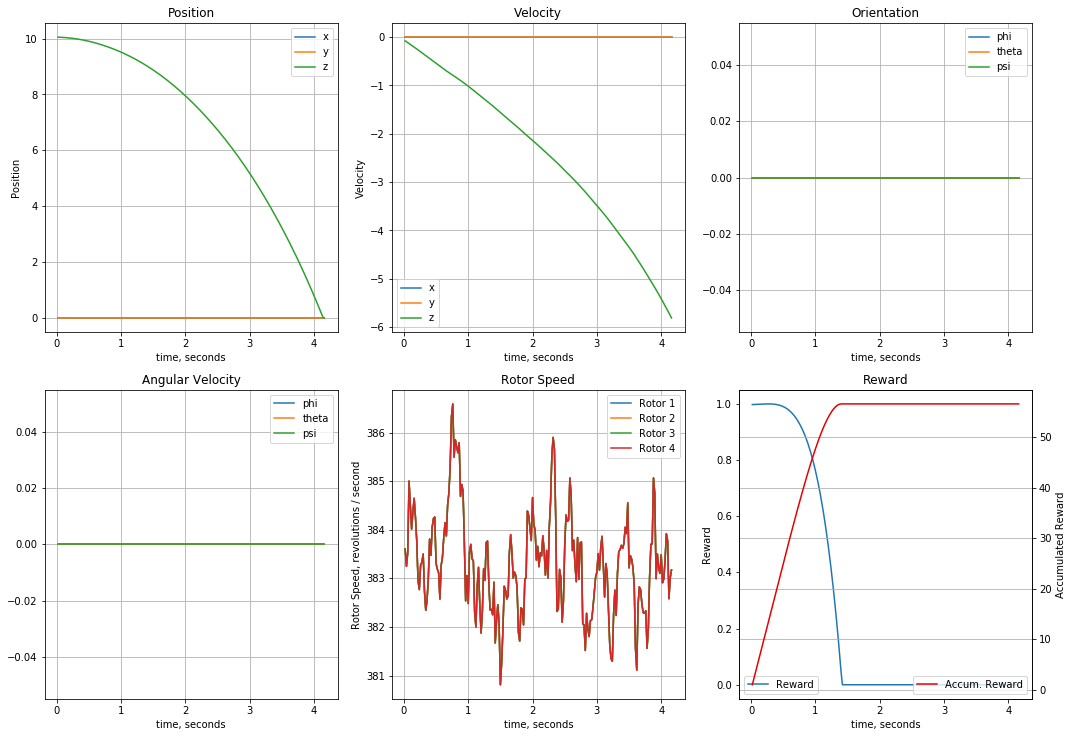

In [54]:
# Modify the values below to give the quadcopter a different starting position.
runtime = 5.                                     # time limit of the episode
init_pose = np.array([0., 0., 10., 0., 0., 0.])  # initial pose
init_velocities = np.array([0., 0., 0.])         # initial velocities
init_angle_velocities = np.array([0., 0., 0.])   # initial angle velocities
target_position = np.array([0.0, 0.0, 10.0])
file_output = 'demo_data.txt'                    # file name for saved results

# Setup
# Setup task and agent
task = Task(init_pose=init_pose, 
            target_pos=target_position,
            pos_noise=0.25,
            ang_noise=0.02, # about 6.8 deg at 6 sigma.
            vel_noise=0.25,
            ang_vel_noise=0.1
           )
basic_agent = Basic_Agent(task)

done = False
labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4', 
          'reward']
results = {x : [] for x in labels}
states = []
# Run the simulation, and save the results.
task.reset()
with open(file_output, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(labels)
    score = 0.0
    while True:
        rotor_speeds = basic_agent.act()
        state, reward, done = task.step(rotor_speeds)
        score += reward
        to_write = [task.sim.time] 
        to_write += list(task.sim.pose) 
        to_write += list(task.sim.v) 
        to_write += list(task.sim.angular_v) 
        to_write += list(task.sim.rotor_speeds) 
        to_write += [reward]
        
        states.append(state)
        for ii in range(len(labels)):
            results[labels[ii]].append(to_write[ii])
        writer.writerow(to_write)
        if done:
            break
    print(score)
            
util.plot_run(results)

When specifying a task, you will derive the environment state from the simulator.  Run the code cell below to print the values of the following variables at the end of the simulation:
- `task.sim.pose` (the position of the quadcopter in ($x,y,z$) dimensions and the Euler angles),
- `task.sim.v` (the velocity of the quadcopter in ($x,y,z$) dimensions), and
- `task.sim.angular_v` (radians/second for each of the three Euler angles).

In [30]:
# the pose, velocity, and angular velocity of the quadcopter at the end of the episode
print("Position:    ", task.sim.pose[:3])
print("Orientation: ", task.sim.pose[3:])
print("Velocity:    ", task.sim.v)
print("Angular vel: ", task.sim.angular_v)

Position:     [-8.7508983  -7.25355043  8.56002176]
Orientation:  [6.02550993 0.43654161 6.19593726]
Velocity:     [-7.27297366 -5.56851958 -1.84810187]
Angular vel:  [ 0.01157734  0.21108755 -0.0191879 ]


In the sample task in `task.py`, we use the 6-dimensional pose of the quadcopter to construct the state of the environment at each timestep.  However, when amending the task for your purposes, you are welcome to expand the size of the state vector by including the velocity information.  You can use any combination of the pose, velocity, and angular velocity - feel free to tinker here, and construct the state to suit your task.

## The Task

A sample task has been provided for you in `task.py`.  Open this file in a new window now. 

The `__init__()` method is used to initialize several variables that are needed to specify the task.  
- The simulator is initialized as an instance of the `PhysicsSim` class (from `physics_sim.py`).  
- Inspired by the methodology in the original DDPG paper, we make use of action repeats.  For each timestep of the agent, we step the simulation `action_repeats` timesteps.  If you are not familiar with action repeats, please read the **Results** section in [the DDPG paper](https://arxiv.org/abs/1509.02971).
- We set the number of elements in the state vector.  For the sample task, we only work with the 6-dimensional pose information.  To set the size of the state (`state_size`), we must take action repeats into account.  
- The environment will always have a 4-dimensional action space, with one entry for each rotor (`action_size=4`). You can set the minimum (`action_low`) and maximum (`action_high`) values of each entry here.
- The sample task in this provided file is for the agent to reach a target position.  We specify that target position as a variable.

The `reset()` method resets the simulator.  The agent should call this method every time the episode ends.  You can see an example of this in the code cell below.

The `step()` method is perhaps the most important.  It accepts the agent's choice of action `rotor_speeds`, which is used to prepare the next state to pass on to the agent.  Then, the reward is computed from `get_reward()`.  The episode is considered done if the time limit has been exceeded, or the quadcopter has travelled outside of the bounds of the simulation.

In the next section, you will learn how to test the performance of an agent on this task.

## The Agent

The sample agent given in `agents/policy_search.py` uses a very simplistic linear policy to directly compute the action vector as a dot product of the state vector and a matrix of weights. Then, it randomly perturbs the parameters by adding some Gaussian noise, to produce a different policy. Based on the average reward obtained in each episode (`score`), it keeps track of the best set of parameters found so far, how the score is changing, and accordingly tweaks a scaling factor to widen or tighten the noise.

Run the code cell below to see how the agent performs on the sample task.

In [ ]:
from agents.policy_search import PolicySearch_Agent

num_episodes = 1000

init_pose = np.array([0.0, 0.0, 10.0, 
                      0.0, 0.0, 0.0])
target_pos = np.array([0., 0., 10.])
task = Task(init_pose=init_pose, target_pos=target_pos)
agent = PolicySearch_Agent(task) 

for i_episode in range(1, num_episodes+1):
    state = agent.reset_episode() # start a new episode
    while True:
        action = agent.act(state) 
        next_state, reward, done = task.step(action)
        agent.step(reward, done)
        state = next_state
        if done:
            print("\rEpisode = {:4d}, score = {:7.3f} (best = {:7.3f}), noise_scale = {}".format(
                i_episode, agent.score, agent.best_score, agent.noise_scale), end="")  # [debug]
            break
    sys.stdout.flush()

In [ ]:
results = util.log_run(agent, 'policy_search.csv')
util.plot_run(results)

This agent should perform very poorly on this task.  And that's where you come in!

## Define the Task, Design the Agent, and Train Your Agent!

Amend `task.py` to specify a task of your choosing.  If you're unsure what kind of task to specify, you may like to teach your quadcopter to takeoff, hover in place, land softly, or reach a target pose.  

After specifying your task, use the sample agent in `agents/policy_search.py` as a template to define your own agent in `agents/agent.py`.  You can borrow whatever you need from the sample agent, including ideas on how you might modularize your code (using helper methods like `act()`, `learn()`, `reset_episode()`, etc.).

Note that it is **highly unlikely** that the first agent and task that you specify will learn well.  You will likely have to tweak various hyperparameters and the reward function for your task until you arrive at reasonably good behavior.

As you develop your agent, it's important to keep an eye on how it's performing. Use the code above as inspiration to build in a mechanism to log/save the total rewards obtained in each episode to file.  If the episode rewards are gradually increasing, this is an indication that your agent is learning.

In [49]:
from agents.agent import DDPG
from ounoise import OUNoise

# Settings
num_episodes = 100
runtime = 5.0
init_pose = np.array([0.0, 0.0, 10.0, 0.0, 0.0, 0.0])
target_position = np.array([0.0, 0.0, 10.0])

# Setup task and agent
task = Task(init_pose=init_pose, 
            target_pos=target_position,
            pos_noise=0.25,
            ang_noise=None, # 0.02 about 6.8 deg at 6 sigma.
            vel_noise=0.1,
            ang_vel_noise=None
           )



noise_annealing = 0.002
noise_min_sigma = 0.01

# Restart training?
if False:
    agent = DDPG(task)
    scores = []
    grades = []
    avg_reward = []
    best_score = -np.inf
    noise = OUNoise(task.action_size, mu=0.0, theta=0.15, sigma=0.1)
    
# Give agent control
for i_episode in range(1, num_episodes+1):
    # Run with added noise
    state = agent.reset_episode() # start a new episode
    noise.reset(noise_annealing, noise_min_sigma)
    score = 0.0
    steps = 0
    while True:
        action = agent.act(state) 
        action += noise.sample()
        action = np.clip(action, -1, 1)

        next_state, reward, done = agent.task.step(action)
        agent.step(action, reward, next_state, done)
        
        state = next_state
        score += reward
        steps += 1
        if done:
            break
            
    avg_reward.append(score/max(1, steps))
    scores.append(score)
    if score > best_score:
        best_score = score 

    text = "\r"
    text += "Episode: {:4d}, ".format(len(scores))
    text += "score: {:.1f}, ".format(score)
    text += "avg_score: {:.1f}, ".format(np.mean(scores[-25:]))
    text += "best: {:.1f}, ".format(best_score)
    text += "avg_reward: {:.1f}, ".format(avg_reward[-1])
    text += "memory: {}, ".format(len(agent.memory))
    text += "sigma: {:.3f}, ".format(noise.sigma)
    text += "  "
    print(text, end="")
    sys.stdout.flush()

Episode:   35, score: 250.9, avg_score: 226.5, best: 250.9, avg_reward: 1.0, memory: 7269, sigma: 0.093,   

KeyboardInterrupt: 

## Plot the Rewards

Once you are satisfied with your performance, plot the episode rewards, either from a single run, or averaged over multiple runs. 

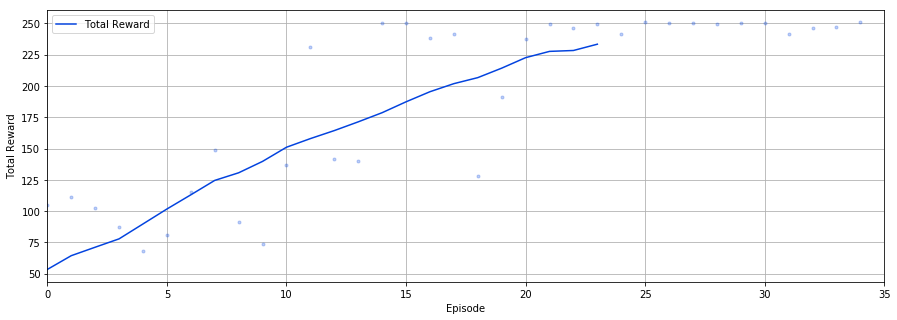

In [50]:
smooth = 21
plt.figure(figsize=(15,5))
plt.plot(scores, '.', alpha=0.25, color='xkcd:blue')
plt.plot(np.convolve(scores, np.ones(smooth)/smooth)[(smooth-1)//2:-smooth], 
         color='xkcd:blue', 
         label='Total Reward')
plt.ylabel('Total Reward')
plt.legend(loc=2)
plt.grid(True)

# plt.twinx()
# plt.plot(avg_reward, '.', alpha=0.25, color='xkcd:green')
# plt.plot(np.convolve(avg_reward, np.ones(smooth)/smooth)[(smooth-1)//2:-smooth], 
#          color='xkcd:green', 
#          label='Avg Reward per Step')
# plt.ylabel('Average Reward per Step')
# plt.legend(loc=1)

plt.xlabel("Episode")
plt.xlim(0, len(scores))
# plt.ylim(np.mean(scores)-1*np.std(scores), np.mean(scores)+1*np.std(scores))
plt.show()

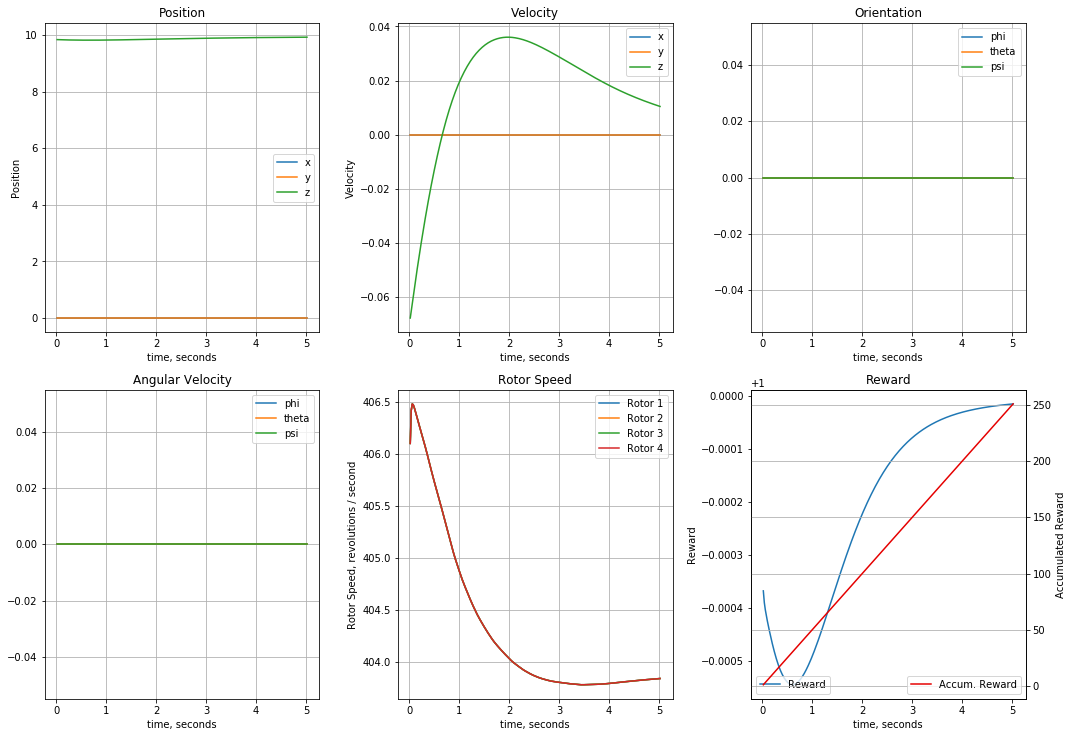

In [51]:
results = util.log_run(agent, 'DDPG.csv')
util.plot_run(results)

## Reflections

**Question 1**: Describe the task that you specified in `task.py`.  How did you design the reward function?

**Answer**:

The task the agent was given was a hover task with the action space constrained to 1 to limit quadcopter motion to z-axis only.  The state given the to agent includes the position error, velocity and acceleration in the z-axis.

The reward function is based on [Huber loss](https://en.wikipedia.org/wiki/Huber_loss).  To give a reward with a clipped range I subtract the Huber loss from the maximum value that I want to allow for the reward, 1, and then clip the lower values at 0.  This gives me a nice reward function that is bounded from 0 to 1 with some of the benifits of both an absolute and squared loss.

**Question 2**: Discuss your agent briefly, using the following questions as a guide:

- What learning algorithm(s) did you try? What worked best for you?
- What was your final choice of hyperparameters (such as $\alpha$, $\gamma$, $\epsilon$, etc.)?
- What neural network architecture did you use (if any)? Specify layers, sizes, activation functions, etc.

**Answer**:

With the continious action and state space of the problem I used a Actor Critic agent.  The agent's actor uses three hidden layers sized 300, 400 and 200 with leaky relu activations and batch normalization.  The final layer uses a tanh activation to scale the output between -1 and 1.  This seems more in line with standard then using the sigmoid it also is a less sensitive than the sigmoid since it has twice the range. The critic uses two branches initially to process the state and actions.  The state branch uses two layers sized 300 and 400 with bach normalization and leaky relu activations.  The action branch uses a single layer of size 400 with batch noramalization and a leaky relu.  The two branches are merged together by adding and followed by the final hidden layer sized 200 and the output layer using no activation function and a narrow kernel initialization around 0.

I used a actor learning rate of 1e-4 and a critic learning rate of 1e-2.  The soft update parameter, tau, was set a 1e-3.  The dicount factor, gamma, was set at 0.95.

I trained the network with a batch size of 128 for 100 epochs.

I also experiemented with a resnet style network since I had siginificat issues with what acted like vanishing and exploding gradients.

**Question 3**: Using the episode rewards plot, discuss how the agent learned over time.

- Was it an easy task to learn or hard?
- Was there a gradual learning curve, or an aha moment?
- How good was the final performance of the agent? (e.g. mean rewards over the last 10 episodes)

**Answer**:

I first worked to learn the hover task.  After a significat amount of failure, I started to reduce the complexity of the task.  To reduce complexity I set all rotor speed to be the same and reduced the action space of the agent to 1.  The state space I reduced to just the position, velocity and acceleration along the z-axis.  This trains well and would be a good starting point to start expanding control to additional dimensions.  This is what I'll be focusing on next.

The learning starts with little progress then ramps fairly quickly to an optimal policy.  After continued training an overtraing effect occurs and the agent's performance degrades or oscilates.

Each training results in different performance.  In some cases the agent quickly moves to the target position with great control and stability.  In some cases, it oscillates as in the case below.  

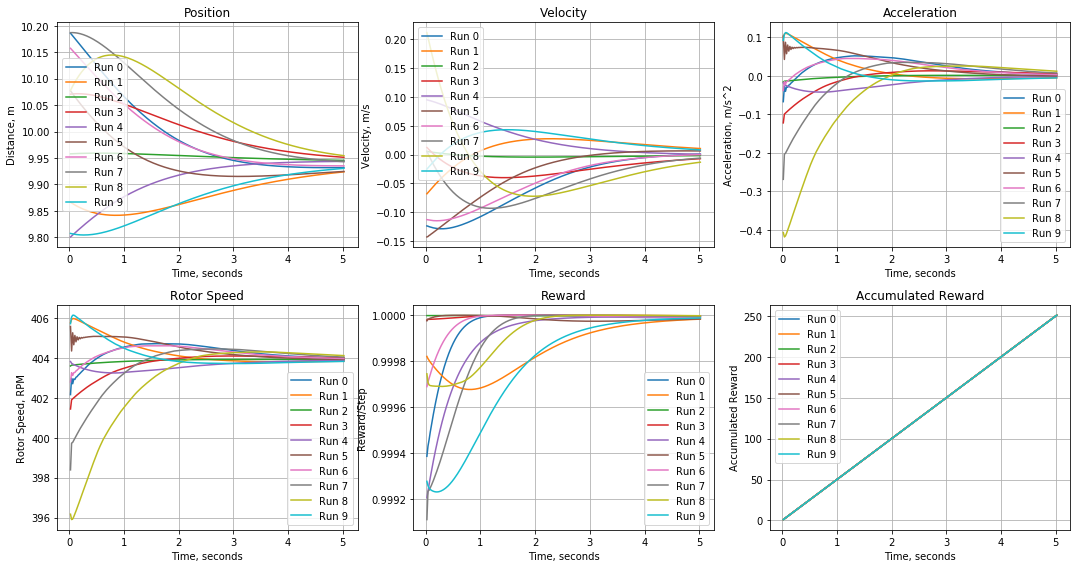

Average accumulated reward over the last 10 runs is 250.982 out of 251 possible or 99.993%


In [52]:
from util import grade
grade(agent, 'test.csv', 10)

**Question 4**: Briefly summarize your experience working on this project. You can use the following prompts for ideas.

- What was the hardest part of the project? (e.g. getting started, plotting, specifying the task, etc.)
- Did you find anything interesting in how the quadcopter or your agent behaved?

**Answer**:

The hardest part was getting a starting point to start iterating.  With so many moving parts it is hard to know what is working or broken until you can see some progress.  I did all of my inital validation in the OpenAI Pendulum environment to verify that my agent was working properly.  After that I focused on the reward function.  In hindsight, I should have reduced the action space sooner so I could get an agent that could learn then slowly add in additional control.  Now that I have an agent that trains consistently I can do testing with expanding state and actions spaces.  I found that by just adding acceleration to my state space added about 50% to the number of episodes to learn the same task with the same agent.  Knowing this it now seems foolish that I was attempting the full state, action space first.

I find it very interesting how in many cases the agent will not look like it is making any real progress and then within just a few episodes it will drastically improve to perfection.  While interesting is difficult for trouble shooting.

I think to tackle the full control problem will require some structured learning as the control problem is quite complex to learn all at once.  
